# GLLVM Longitudinal

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR # scheduler
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import copy

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:500mb" # this ist to prevent cuda to reserve too much memory


# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


### Loading data
The data has been pre-processed as a 3D array with dimensions given by $(n, k+p, T)$.

The final array is a 3D array of shape (n, k+p, T), where 
* n is the number of observations, 
* k is the number of covariates,
* p is the number of responses to be modeled by the latent variables,
* T is the number of time observations

The variables are ordered as follows:

**Covariates**

- age (covariate)
- gender (covariate)
- education (covariate)

**Responses**

- month (binary)
- day (binary)
- year (binary)
- day_week (binary)
- paper (binary)
- cactus (binary)
- president (binary)
- vice_president (binary)
- serie_7 (count)
- backwards (ordinal)
- recall_immediate (count)
- recall_delayed (count)

The binary random variables are modelled conditionally with a logistic regression; the ordinal variables with an ordinal logistic regression; the counts with poisson regression.

The ordinal responses require an intercept for each level, or "cutpoints". In our case, we model this by hard-coding the intercept, but it should be made more general. We assume the effect of the covariates is constant across categories, resulting in a proportional odds model.

Since the ordinal variable has only 3 categories (0,1,2) and that 2 has very few non-zero elements, we will merge categories 1 and 2 and consider it as a bernoulli random variable.

**Covariates**

- 0: age (covariate)
- 1: gender (covariate)
- 2: education (covariate)

**Responses**

- 0: month (binary)
- 1: day (binary)
- 2: year (binary)
- 3: day_week (binary)
- 4: paper (binary)
- 5: cactus (binary)
- 6: president (binary)
- 7: vice_president (binary)
- 8: serie_7 (count)
- 9: backwards (dummy)
- 10: recall_immediate (count)
- 11: recall_delayed (count)

In [2]:
# Import the preprocessed data
data = np.load("../data/HRS/HRS_3Darray.npy")
data.shape

(33146, 15, 9)

In [3]:
# Create the backwards dummy
data[:,12] = (data[:,12]>=1)

In [4]:
# Transpose the data from (batch_length, num_features, seq_length) to  (batch_length, seq_length, num_features)
# Separate covariates and responses, and prepare the torch tensors
data = np.transpose(data, (0,2,1))
data_true = {
    'x': torch.from_numpy(data[:,:,:3]).float(),
    'y': torch.from_numpy(data[:,:,3:]).float()
}

# Missing data: create the mask and initialize imputed values

##  dealing with missing data
We deal with missing data in two ways:

* The missing values are iteratively imputed by their conditional mean.
* To compute the Z, we use the imputed means.
* To compute the parameters, we use the imputed means and estimated Z but *provide the mask* so that the update does not take the missing values into account in the computation of the gradient.


In [5]:
mask = {}

mask['x'] = torch.isnan(data_true['x'])
mask['y'] = torch.isnan(data_true['y'])

data_true['x'][mask['x']] = 0.5
data_true['y'][mask['y']] = 0.5


In [6]:
torch.mean(mask['y']*1.0)

tensor(0.5634)

# Data standardization

To improve numerical stability, we transform the counts as $y\to \log(y+1)$. This is reflected in the sampling mechanics. As a result, we use the identity as a link function for the counts.

In [7]:
# Numerical stability issues for poisson data
data_true['x'][:,:,0] = data_true['x'][:,:,0] /20


# Add time information
time_data = torch.from_numpy(np.linspace(0,4,9)).float().expand(data_true['x'].shape[0], -1).unsqueeze(2)

data_true['x'] = torch.cat([data_true['x'], time_data], dim=2)


In [8]:

response_types = {
    'binary': [0,1,2,3,4,5,6,7],
    'ordinal': [9, 10],
    'counts': [8, 11, 12]
}

link = {
    'binary' : lambda x: torch.logit(x),
    'ordinal': lambda x: torch.logit(x),
    'counts': lambda x: torch.log(x)
}


linkinv_decoder = {
    'binary': lambda x: 1/(1+torch.exp(-x)),
    'ordinal': lambda x: 1/(1+torch.exp(-x)),
    'counts': lambda x: torch.exp(x) # see below remarks for the standardization of the "counts"
}

response_transform = {
    'binary' : lambda x: 2*x - 1,
    'ordinal': lambda x: 2*x - 1,
    'counts': lambda x: torch.log(x+1)
}


## Building the GLLVM Longitudinal Model

A Longitudinal GLLVM is a model with 1 variable per period for T periods, n observations, and p responses, and k covariates. We also have a random effect for each observation x response.

In [9]:
n = data_true['y'].shape[0]
p = 12
q = 1
k = 4
T = 9

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)
DIMENSIONS_U = (n, 1, p)

In [10]:
response_types = {
    'binary': [0,1,2,3,4,5,6,7, 9],
    'counts': [8, 10, 11]
}

link = {
    'binary' : lambda x: torch.logit(x),
    'ordinal': lambda x: torch.logit(x),
    'counts': lambda x: torch.log(x)
}


linkinv = {
    'binary': lambda x: 1/(1+torch.exp(-x)),
    'ordinal': lambda x: 1/(1+torch.exp(-x)),
    'counts': lambda x: torch.exp(x)
}

response_transform = {
    'binary' : lambda x: 2*x - 1,
    'ordinal': lambda x: 2*x - 1,
    'counts': lambda x: torch.log(x+1)
}


They can be of many response types. Here for the sake of illutration we will consider 3 response types: gaussian, binary, and poisson.

We allow for transformation of the data, which we account for in the estimation. In particular, Poisson data may be numerically problematic because their conditional expectation is the exponential of the linear predictor. Small differences in the latter can result in dramatic differences in the gradient. For instance, we can transform poisson with the following function $x \rightarrow \log(x+1)$. This transforms is needed in 2 places: for encoding, and at the loss function for computing the gradient.

## Computing the scale parameter

The scale parameter is computed in a second step (on the fit residual). They are updated at every iteration.


### Modules

We need LongitudinalGLLVM as the overarching module, Sample which samples the data and takes additional arguments (such as nuisance parameters), Decoder which contains all the parameters of interest, and Encoder which encodes the data using a Neural Network.

### Design of the Encoder
Since the estimation problem for Z is the same at each time step, we model the encoder using a RNN. At each time step, the same encoder is used to compute the Z. At the same time, the hidden state of the RNN is used to predict the U variable, which is constant over time for each observation.

In [11]:
class LongitudinalGLLVM(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.sample = Sample(self.decoder)
    
    def plot_cov(self, what="linpar", x=None, cor=False):
        data_sample = self.sample(x=x)
        data =  data_sample[what].detach().view(n, -1).numpy()

        if cor:
            cov_matrix = np.corrcoef(data, rowvar=False)
        else:
            cov_matrix = np.cov(data, rowvar=False)


        plt.figure(figsize=(10,10))
        sns.heatmap(cov_matrix, annot=False, fmt='g')
        plt.show()

    def impute(self, x, y, mask, nsteps=10):
        """ Impute the missing values provided by the mask (True is missing) and return x imputed"""
        for _ in range(nsteps):
            z, u = self.encoder(x,y)
            y_decoded, _ = self.decoder(x,z,u)
            y[mask] = y_decoded[mask]
        return y

class Sample(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.decoder = decoder
        self.phi = torch.ones(1).to(device) * .8
        self.var_u = torch.ones(1).to(device) * 0.2

    # sampling comes here
    
    def forward(self, x):
        with torch.no_grad():
            if x is None:
                Warning("x was set to None for sampling. X is usually fixed. Are you sure you want to sample x?")
                x = torch.randn((n, T, k)).to(device)

            u = torch.randn((n, 1, p)).to(device) * torch.sqrt(self.var_u)
            d = torch.randn((n, T, q)).to(device)
            z = self.AR(d)

            linpar, mean = self.decoder(x, z, u) # decoder gives the expectation

            y = self.sample_response(mean)

            return {"x":x, "y":y, "z":z, "u":u, "linpar":linpar, "mean":mean}

    def sample_response(self, mean):
            y = torch.zeros_like(mean)
            for response_type, response_id in response_types.items():
                if response_type == "binary":
                    y[:,:,response_id] = torch.bernoulli(mean[:,:,response_id])
                elif response_type == "ordinal":
                    cum_probs = mean[:,:,response_id]
                    # draw one uniform for the whole vector
                    random = torch.rand((*cum_probs.shape[0:2], 1)) 
                    # compare with the cumulative probabilities
                    ordinal = torch.sum(random > cum_probs, dim=2)
                    ordinal = torch.nn.functional.one_hot(ordinal).squeeze().float()
                    ordinal = ordinal[:,:,1:] # discard the first column of the one_hot encoding, as it is superfluous (as a 0)
                    y[:,:,response_id] = ordinal
                elif response_type == "counts":
                    y[:,:,response_id] = torch.poisson(mean[:,:,response_id])
            return y

    def AR(self, d):
        z = d.clone()

        for t in range(1, z.shape[1]):
            z[:,t] = z[:,t] + z[:, t-1] * self.phi  # TODO we need to clone z[:, t-1] ? else the gradient wants to pass through it

        return z
                
    
class Decoder(nn.Module):
    # Yields the expectation
    def __init__(self):
        super().__init__()

        # decoder part (our parameters of interest)
        self.wz = nn.Parameter(torch.rand((q, p)))
        self.wx = nn.Parameter(torch.randn((1, k, p))*0.4)
        self.bias = nn.Parameter(torch.randn((1, 1, p))*0.0)

    # decoding (computing the conditional mean)
    def forward(self, x, z, u):

        xwx = (x.unsqueeze(2) @ self.wx).squeeze() # see section "details of tensorproducts"
        zwz = (z.unsqueeze(2) @ self.wz).squeeze()
        # for the ordinal variables:
        linpar = self.bias + xwx + zwz + u 

        # Apply the inverse link to get the conditional expectation
        mean  = torch.zeros_like(linpar)
        for response_type, response_id in response_types.items():
            mean[:,:,response_id] = linkinv[response_type](linpar[:,:,response_id])
        # Transform the 
        return linpar, mean



class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder part
        # input dimension is (p+k) (responses + covariates)
        # output dimension is q+p (one latent )
        input_size = p + k
        hidden_size = (p + q) * 5
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
        )
        # fully connected layers for Z and U
        self.fc_Z = nn.Sequential(
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = q),
        )

        self.fc_U = nn.Sequential(
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features = p)
        )

        self.optimizer =  torch.optim.Adam(self.parameters(), lr=.01)
        self.scheduler = StepLR(self.optimizer, step_size=50, gamma=1)
        self.loss = nn.MSELoss()

    
    def forward(self, x, y, transform_response = False):
        # Initialize hidden state

        # pass the input through the RNN
        if transform_response:
            y_transformed = torch.zeros_like(y)
            with torch.no_grad():
                for response_type, response_id in response_types.items():
                    y_transformed[:,:,response_id] = response_transform[response_type](y[:,:,response_id])
        else:
            y_transformed = y

        xy = torch.cat([x, y_transformed], dim=2)
        rnn_out, _ = self.rnn(xy)
        out = self.fc(rnn_out)
        z_pred = self.fc_Z(out)
        u_pred = self.fc_U(out[:, -1, :]).unsqueeze(1)
        return z_pred, u_pred
    
    def fit(self, x, y, z, u, epochs = 100, verbose = False):
        y_transform = torch.zeros_like(y)
        with torch.no_grad():
            for response_type, response_id in response_types.items():
                y_transform[:,:,response_id] = response_transform[response_type](y[:,:,response_id])
        # Fit the encoder
        for epoch in range(epochs):
            self.optimizer.zero_grad()

            z_pred, u_pred = self(x, y_transform, transform_response = False)

            loss = self.loss(z_pred, z) + self.loss(u_pred, u)

            if verbose:
                print(f"\nEpoch {epoch}/{epochs}, loss={loss}")
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

        return loss
    
    def plot(self, x, y, z, u):
        with torch.no_grad():
            z_pred, u_pred = self(x, y, transform_response = True)

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

        ax1.scatter(z, z_pred)
        ax1.set_xlabel('Z True')
        ax1.set_ylabel('Z Pred')
        ax1.set_title('Encoded values of Z')
        ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", color="red")

        ax2.scatter(u, u_pred)
        ax2.set_xlabel('U True')
        ax2.set_ylabel('U Pred')
        ax2.set_title('Encoded values of U')
        ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", color="red")


        plt.show()
        


class MELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y, linpar, ys, linpars, mask=None):
        """Computes the loss. hat is recontructed y, ys is simulated"""
        y_transformed = torch.zeros_like(y)
        ys_transformed = torch.zeros_like(ys)
        with torch.no_grad():
            for response_type, response_id in response_types.items():
                y_transformed[:,:,response_id] = response_transform[response_type](y[:,:,response_id])
                ys_transformed[:,:,response_id] = response_transform[response_type](ys[:,:,response_id])

        if mask is None:
            loss = -torch.mean(y_transformed* linpar - ys_transformed * linpars) * y.shape[1] * y.shape[2]
        else:
            loss = -torch.sum((y_transformed* linpar - ys_transformed * linpars) * ~mask) * y.shape[1] * y.shape[2] / torch.sum(~mask)

        return loss
        # return torch.mean(torch.pow(y-linpar, 2) - torch.pow(ys - linpars, 2))
        # loss = torch.mean(y.T @ linpar - ys.T @linpars)/y.shape[0]
        # return loss


In [12]:
# Ok now here we go!
# ------------------
data_sample = {key:data.to(device) for key, data in data_true.items()}
mask = {key:data.to(device) for key, data in mask.items()}

model = LongitudinalGLLVM().to(device)
criterion = MELoss()
optimizer = torch.optim.SGD(model.decoder.parameters(), lr=.01)
scheduler = StepLR(optimizer, step_size=10, gamma=1.0)
mseLoss = nn.MSELoss()
epochs = 500

def compute_autocorr(z):
    # Compute the sample autocovariance and autocorrelation
    autocovariance = torch.mean((z[:, 1:] - torch.mean(z[:, 1:])) * (z[:, :-1] - torch.mean(z[:, :-1])), dim=1)
    autocorrelation = autocovariance / torch.var(z[:, :-1])

    # Estimate phi using the autocorrelation formula for AR(1)
    phi = torch.mean(autocorrelation)

    return phi

In [13]:
losses = []
learning_rates = []
learning_rates_encoder = []
param_values = []
wx_values = []
bias = []
max_save = 500

for epoch in range(1, epochs +1):
    optimizer.zero_grad()

    # impute and sample
    with torch.no_grad():
        data_sim = model.sample(x=data_sample["x"])
        zhat_sample, uhat_sample = model.encoder(data_sample["x"], data_sample["y"], transform_response=True)
        zhat_sim, uhat_sim = model.encoder(data_sim["x"], data_sim["y"], transform_response=True)

    # train the encoder on the simulated data
    encoder_loss = model.encoder.fit(data_sim["x"], data_sim["y"], data_sim["z"], data_sim["u"],  epochs= 10) 

    # compute the decoded value
    linpar_sample, mean_sample = model.decoder(data_sample["x"], zhat_sample, uhat_sample)
    linpar_sim, mean_sim = model.decoder(data_sim["x"], zhat_sim, uhat_sim)

    # Detach mean_sample, which will not be used for backprop anyway. this is to ensure that the following imputation operation doesn'^t create weird things with the 
    # computational graph
    # Use mean_sample to impute.
    # TODO. possibly do the same on the simulated sample to reduce bias further?
    with torch.no_grad():
        data_sample["y"][mask["y"]] = mean_sample[mask["y"]] 

    # Compute the loss
    loss = criterion(data_sample["y"], linpar_sample,  data_sim["y"], linpar_sim, mask['y'])
    loss.backward()

    # # Update nuisance parameters TODO: idea: use the neural net to estimate these directly.
    # with torch.no_grad():
    #     model.sample.var_u = .9* model.sample.var_u + .1 * torch.var(uhat_sample) * (model.sample.var_u / torch.var(uhat_sim))
    #     model.sample.phi = .9 * model.sample.phi + .1 * compute_autocorr(zhat_sample) * model.sample.phi / compute_autocorr(zhat_sim)
    #     if model.sample.phi > .9:
    #         model.sample.phi = torch.ones(1).to(device) * .9 
    #     print(f'var_u: {model.sample.var_u}, phi: {model.sample.phi}')

    with torch.no_grad():   
        fit = mseLoss(mean_sample, data_sample["y"])

    optimizer.step()
    scheduler.step()

    losses.append(fit.item())
    if len(losses) > 100:
        losses.pop(0)

    learning_rates.append(optimizer.param_groups[0]['lr'])
    if len(learning_rates) > max_save:
        learning_rates.pop(0)

    learning_rates_encoder.append(model.encoder.optimizer.param_groups[0]['lr'])
    if len(learning_rates_encoder) > max_save:
        learning_rates_encoder.pop(0)

    param_values.append(model.decoder.wz.clone().detach())
    if len(param_values) > max_save:
        param_values.pop(0)

    wx_values.append(model.decoder.wx.clone().detach())
    if len(wx_values) > max_save:
        wx_values.pop(0)

    bias.append(model.decoder.bias.clone().detach())
    if len(bias) > max_save:
        bias.pop(0)

    print(f"\nEpoch {epoch}/{epochs}, loss_fit = {fit.item():.2f}, encoder_loss = {encoder_loss.item():.2f}.")
    
    del data_sim, zhat_sample, uhat_sample, zhat_sim, uhat_sim, linpar_sample, mean_sample, linpar_sim, mean_sim, fit, loss
    torch.cuda.empty_cache()


Epoch 1/500, loss_fit = 434.72, encoder_loss = 1.29.

Epoch 2/500, loss_fit = 61.45, encoder_loss = 1.04.

Epoch 3/500, loss_fit = 12.74, encoder_loss = 0.71.

Epoch 4/500, loss_fit = 35.01, encoder_loss = 0.72.

Epoch 5/500, loss_fit = 2.30, encoder_loss = 0.71.

Epoch 6/500, loss_fit = 13.39, encoder_loss = 0.69.

Epoch 7/500, loss_fit = 1.34, encoder_loss = 0.69.

Epoch 8/500, loss_fit = 6.45, encoder_loss = 0.66.

Epoch 9/500, loss_fit = 0.93, encoder_loss = 0.68.

Epoch 10/500, loss_fit = 4.51, encoder_loss = 0.64.

Epoch 11/500, loss_fit = 0.89, encoder_loss = 0.73.

Epoch 12/500, loss_fit = 3.97, encoder_loss = 0.68.

Epoch 13/500, loss_fit = 0.97, encoder_loss = 0.86.

Epoch 14/500, loss_fit = 4.50, encoder_loss = 0.87.

Epoch 15/500, loss_fit = 0.85, encoder_loss = 0.96.

Epoch 16/500, loss_fit = 3.87, encoder_loss = 0.79.

Epoch 17/500, loss_fit = 0.93, encoder_loss = 0.94.

Epoch 18/500, loss_fit = 4.43, encoder_loss = 0.83.

Epoch 19/500, loss_fit = 0.94, encoder_loss = 0.

KeyboardInterrupt: 

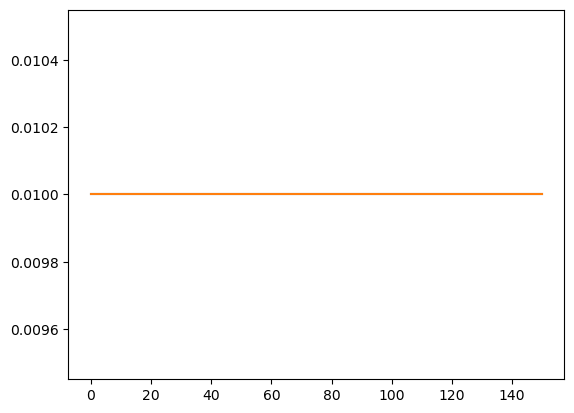

In [14]:
plt.plot(learning_rates)
plt.plot(learning_rates_encoder)

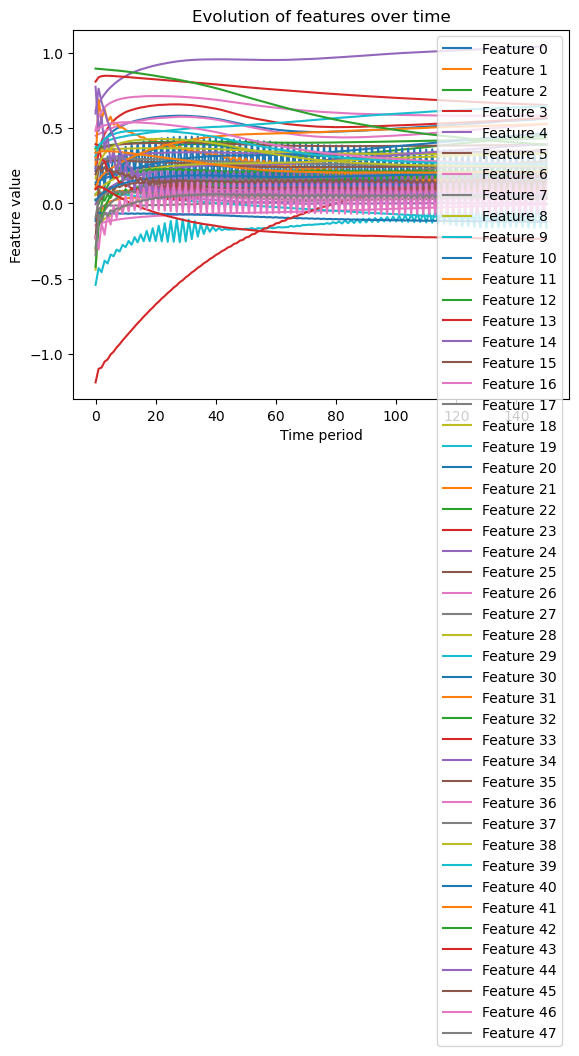

In [15]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in wx_values], axis=0)


# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i], label='Feature '+str(i))  # add label here

# Add legend and labels
ax.legend() # This automatically uses the labels from each plot call
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()

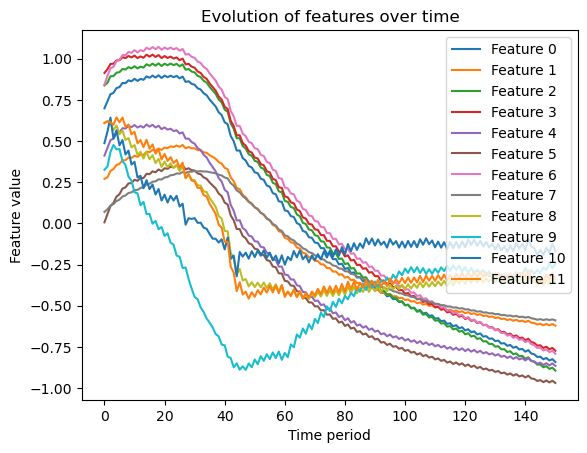

In [16]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in param_values], axis=0)


# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i], label='Feature '+str(i))  # add label here

# Add legend and labels
ax.legend() # This automatically uses the labels from each plot call
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()

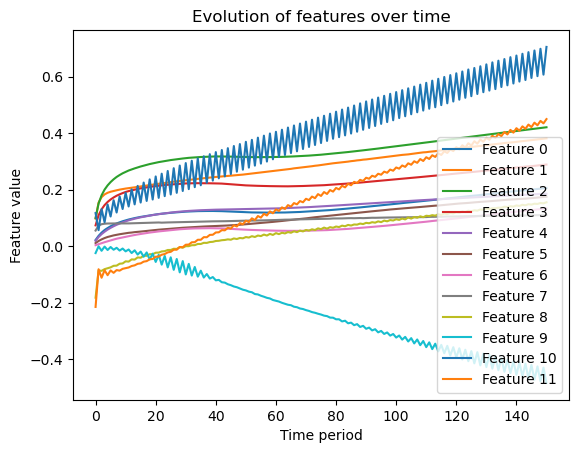

In [17]:
data = np.stack([tensor.flatten().cpu().numpy() for tensor in bias], axis=0)


# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i], label='Feature '+str(i))  # add label here

# Add legend and labels
ax.legend() # This automatically uses the labels from each plot call
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()

torch.Size([33146, 9, 12])


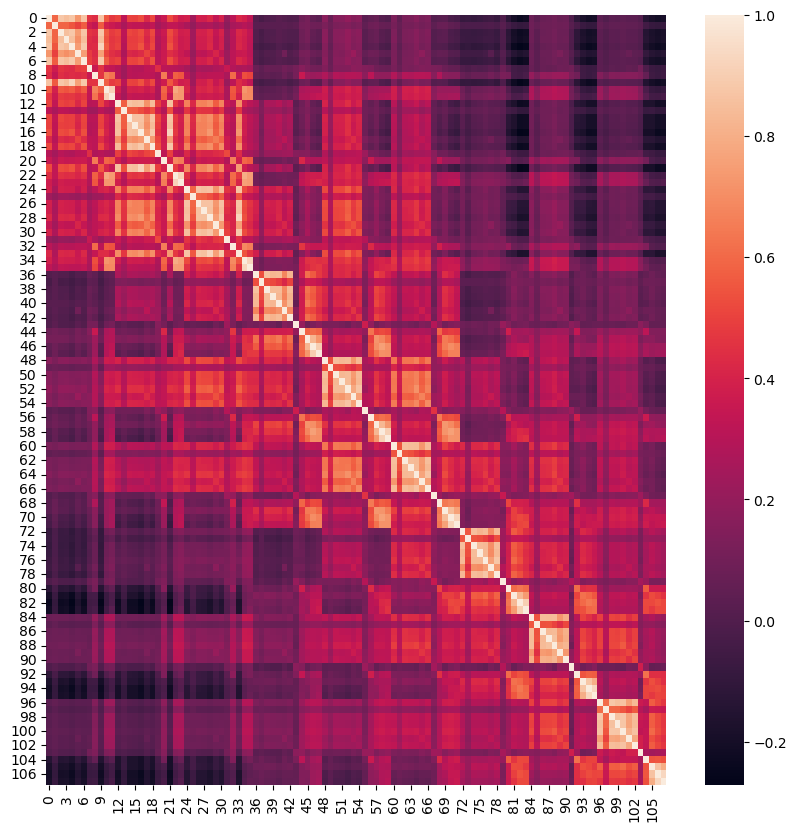

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [18]:
print(data_true['y'].shape)
data =  torch.reshape(data_true['y'].detach(), (data_true['y'].shape[0], -1))
corr_matrix = np.corrcoef(data, rowvar=False)

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=False, fmt='g')
plt.show()

model.plot_cov(what="y", cor=True)

In [ ]:

dat1 = torch.reshape(data_true['y'].cpu().detach(), (data_true['y'].shape[0], -1))
cor1 = np.corrcoef(dat1, rowvar=False)
dat2 = torch.reshape(model.sample(x=data_true['x'])['y'].cpu().detach(), (data_true['y'].shape[0], -1))
cor2 = np.corrcoef(dat2, rowvar=False)

plt.scatter(cor1, cor2)
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_bmm)

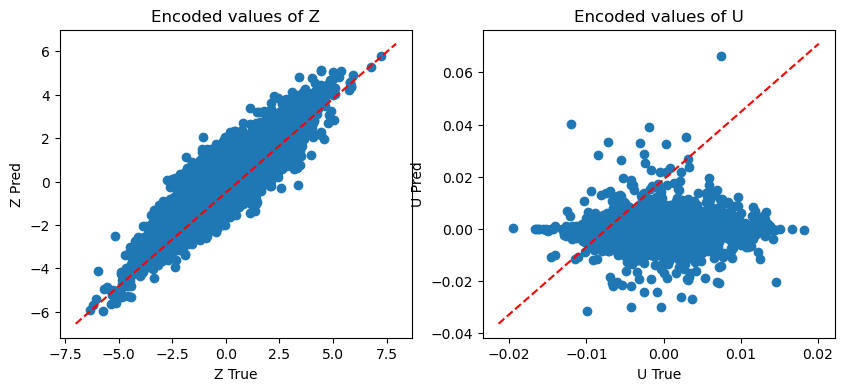

In [ ]:
model.encoder.plot(data_sim['x'], data_sim['y'], data_sim['z'], data_sim['u'])